In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date as date
from datetime import datetime
import holidays
from calendar import monthrange

In [20]:
meter = pd.read_excel("BulkMeterData.xlsx")
meter_by_hour = meter.groupby(np.arange(len(meter))//2).agg({'DateTime':['min'],'Power (kW)':['sum']})
meter_by_hour.columns = meter_by_hour.columns.get_level_values(0)
meter_by_hour['Date'] = meter_by_hour['DateTime']
meter_by_hour['Hour'] = meter_by_hour['Date'].apply(lambda x: x.hour)
meter_by_hour['Date'] = meter_by_hour['Date'].apply(lambda x: x.date())
meter_by_hour['Year'] = meter_by_hour['Date'].apply(lambda x: x.year)
meter_by_hour['Month'] = meter_by_hour['Date'].apply(lambda x: x.month)
meter_by_hour['Day'] = meter_by_hour['Date'].apply(lambda x: x.day)

In [21]:
weather = pd.read_excel("CapeTownWeather.xlsx")

In [22]:
df = pd.merge(meter_by_hour,weather,how='right',left_on=['Year','Month','Day','Hour'], right_on = ['Year','Month','Day','Hour'])
df[8736:]['DateTime'] = datetime(2019,10,13)
df[8736:]['Date'] = df[8736:]['DateTime'].apply(lambda x:x.date())
df

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,DateTime,Power (kW),Date,Hour,Year,Month,Day,Minute,Temperature,Relative Humidity,Total Precipitation,Wind Speed,Wind Direction
0,2018-10-14 00:30:00,18.4442,2018-10-14,0,2018,10,14,0,17.82,65,0.0,8.89,148.24
1,2018-10-14 01:30:00,22.1980,2018-10-14,1,2018,10,14,0,17.86,66,0.0,6.61,150.64
2,2018-10-14 02:30:00,18.9443,2018-10-14,2,2018,10,14,0,17.96,66,0.0,3.67,168.69
3,2018-10-14 03:30:00,24.7582,2018-10-14,3,2018,10,14,0,17.72,68,0.0,9.75,4.24
4,2018-10-14 04:30:00,20.3960,2018-10-14,4,2018,10,14,0,17.01,71,0.0,20.36,351.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2019-10-13 00:00:00,NaN,2019-10-13,19,2019,10,13,0,22.04,61,0.0,15.38,163.69
8756,2019-10-13 00:00:00,NaN,2019-10-13,20,2019,10,13,0,21.57,61,0.0,16.18,147.72
8757,2019-10-13 00:00:00,NaN,2019-10-13,21,2019,10,13,0,20.48,65,0.0,12.98,146.31
8758,2019-10-13 00:00:00,NaN,2019-10-13,22,2019,10,13,0,19.33,70,0.0,11.18,146.82


In [23]:
df.drop(['DateTime','Year','Minute','Day'],axis=1,inplace=True)

In [24]:
df['holiday'] = df['Date'].apply(lambda x: 1 if date(x.year,x.month,x.day) in holidays.ZA() else 0)
df['num_of_week'] = df['Date'].apply(lambda x: x.isocalendar()[1])
df['which_weekday'] = df['Date'].apply(lambda x: x.isocalendar()[2])
df['Month'] = df['Date'].apply(lambda x: x.month)
df.head()

,Power (kW),Date,Hour,Month,Temperature,Relative Humidity,Total Precipitation,Wind Speed,Wind Direction,holiday,num_of_week,which_weekday
0,18.4442,2018-10-14,0,10,17.82,65,0.0,8.89,148.24,0,41,7
1,22.1980,2018-10-14,1,10,17.86,66,0.0,6.61,150.64,0,41,7
2,18.9443,2018-10-14,2,10,17.96,66,0.0,3.67,168.69,0,41,7
3,24.7582,2018-10-14,3,10,17.72,68,0.0,9.75,4.24,0,41,7
4,20.3960,2018-10-14,4,10,17.01,71,0.0,20.36,351.87,0,41,7


In [25]:
X = df.drop(['Power (kW)','Date'],axis=1)
y = df['Power (kW)']
X.columns

Index(['Hour', 'Month', 'Temperature', 'Relative Humidity',
       'Total Precipitation', 'Wind Speed', 'Wind Direction', 'holiday',
       'num_of_week', 'which_weekday'],
      dtype='object')

In [38]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
import xgboost
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings("ignore")

In [39]:
for_standard = ['Temperature', 'Relative Humidity',
       'Total Precipitation', 'Wind Speed', 'Wind Direction']
for_onehot = ['which_weekday','Month','num_of_week','Hour']

In [42]:
def ML_pipeline_xgb_GridSearchCV(X,y,random_state,n_folds):
    '''
    XGB regressor to predict power usage
    '''
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.15, random_state = random_state)
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    standard_transformer = Pipeline(steps=[('standard', StandardScaler())])
    #minmax_transformer = Pipeline(steps=[('minmax', MinMaxScaler())])
    onehot_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    XGB = xgboost.XGBRegressor()
    preprocessor = ColumnTransformer(
    transformers=[
        ('standard', standard_transformer, for_standard),
        #('minmax',minmax_transformer,for_minmax),
        ('onehot',onehot_transformer,for_onehot)])
    reg = Pipeline(steps=[('preprocessor', preprocessor),
                          ('Regressor', XGB)])
    param_grid = { 
    'Regressor__learning_rate': [0.023],
    'Regressor__n_estimators': [300,400],
    'Regressor__max_depth': [3,6,10],
    'Regressor__colsample_bytree': [0.8],  
    'Regressor__random_state' : [random_state]}
    
    grid = GridSearchCV(reg, param_grid=param_grid,scoring = 'neg_mean_squared_error',
                        cv=kf, return_train_score = True,iid=True)
    grid.fit(X_other, y_other)
    
    return grid, grid.score(X_test, y_test)

In [44]:
test_scores_xgb = []
grids = []
for i in range(10):
    grid, test_score = ML_pipeline_xgb_GridSearchCV(X[:8736],y[:8736],(i+1)*42,5)
    print(grid.best_params_)
    print('test score:',test_score)
    grids.append(grid)
    test_scores_xgb.append(test_score)
print('test MSE:',np.around(np.mean(test_scores_xgb),3),'+/-',np.around(np.std(test_scores_xgb),3))

[17:35:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:35:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:35:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:35:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:35:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:35:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:35:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:35:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [54]:
ind = np.argmax(test_scores_xgb)
hourly_prediction_raw = grids[ind].predict(X[8736:])
tot = sum(hourly_prediction_raw)
hourly_prediction = [(prediction/tot)*577.53 for prediction in hourly_prediction_raw]
hourly_prediction

[16.284792895731805,
 14.343980926755082,
 14.03369498877808,
 15.663886228689316,
 16.882622335186536,
 21.274173587268884,
 27.38905963158292,
 27.16872349465901,
 25.206699785182934,
 25.616532349693678,
 24.362582449359106,
 24.835569070501208,
 25.35314986462969,
 26.209835102198504,
 25.445323301377467,
 23.98004236581534,
 24.780227324990488,
 27.42628217195119,
 30.314342703684066,
 35.12111432105001,
 32.959513079304024,
 26.468907346644215,
 25.39307097688794,
 21.01587369807847]

In [56]:
from sklearn.feature_selection import SelectFromModel

In [ ]:
thresholds = sort(grids[ind].best_estimator_[1].feature_importances_)

In [67]:
len(grids[ind].best_estimator_[1].feature_importances_)

100

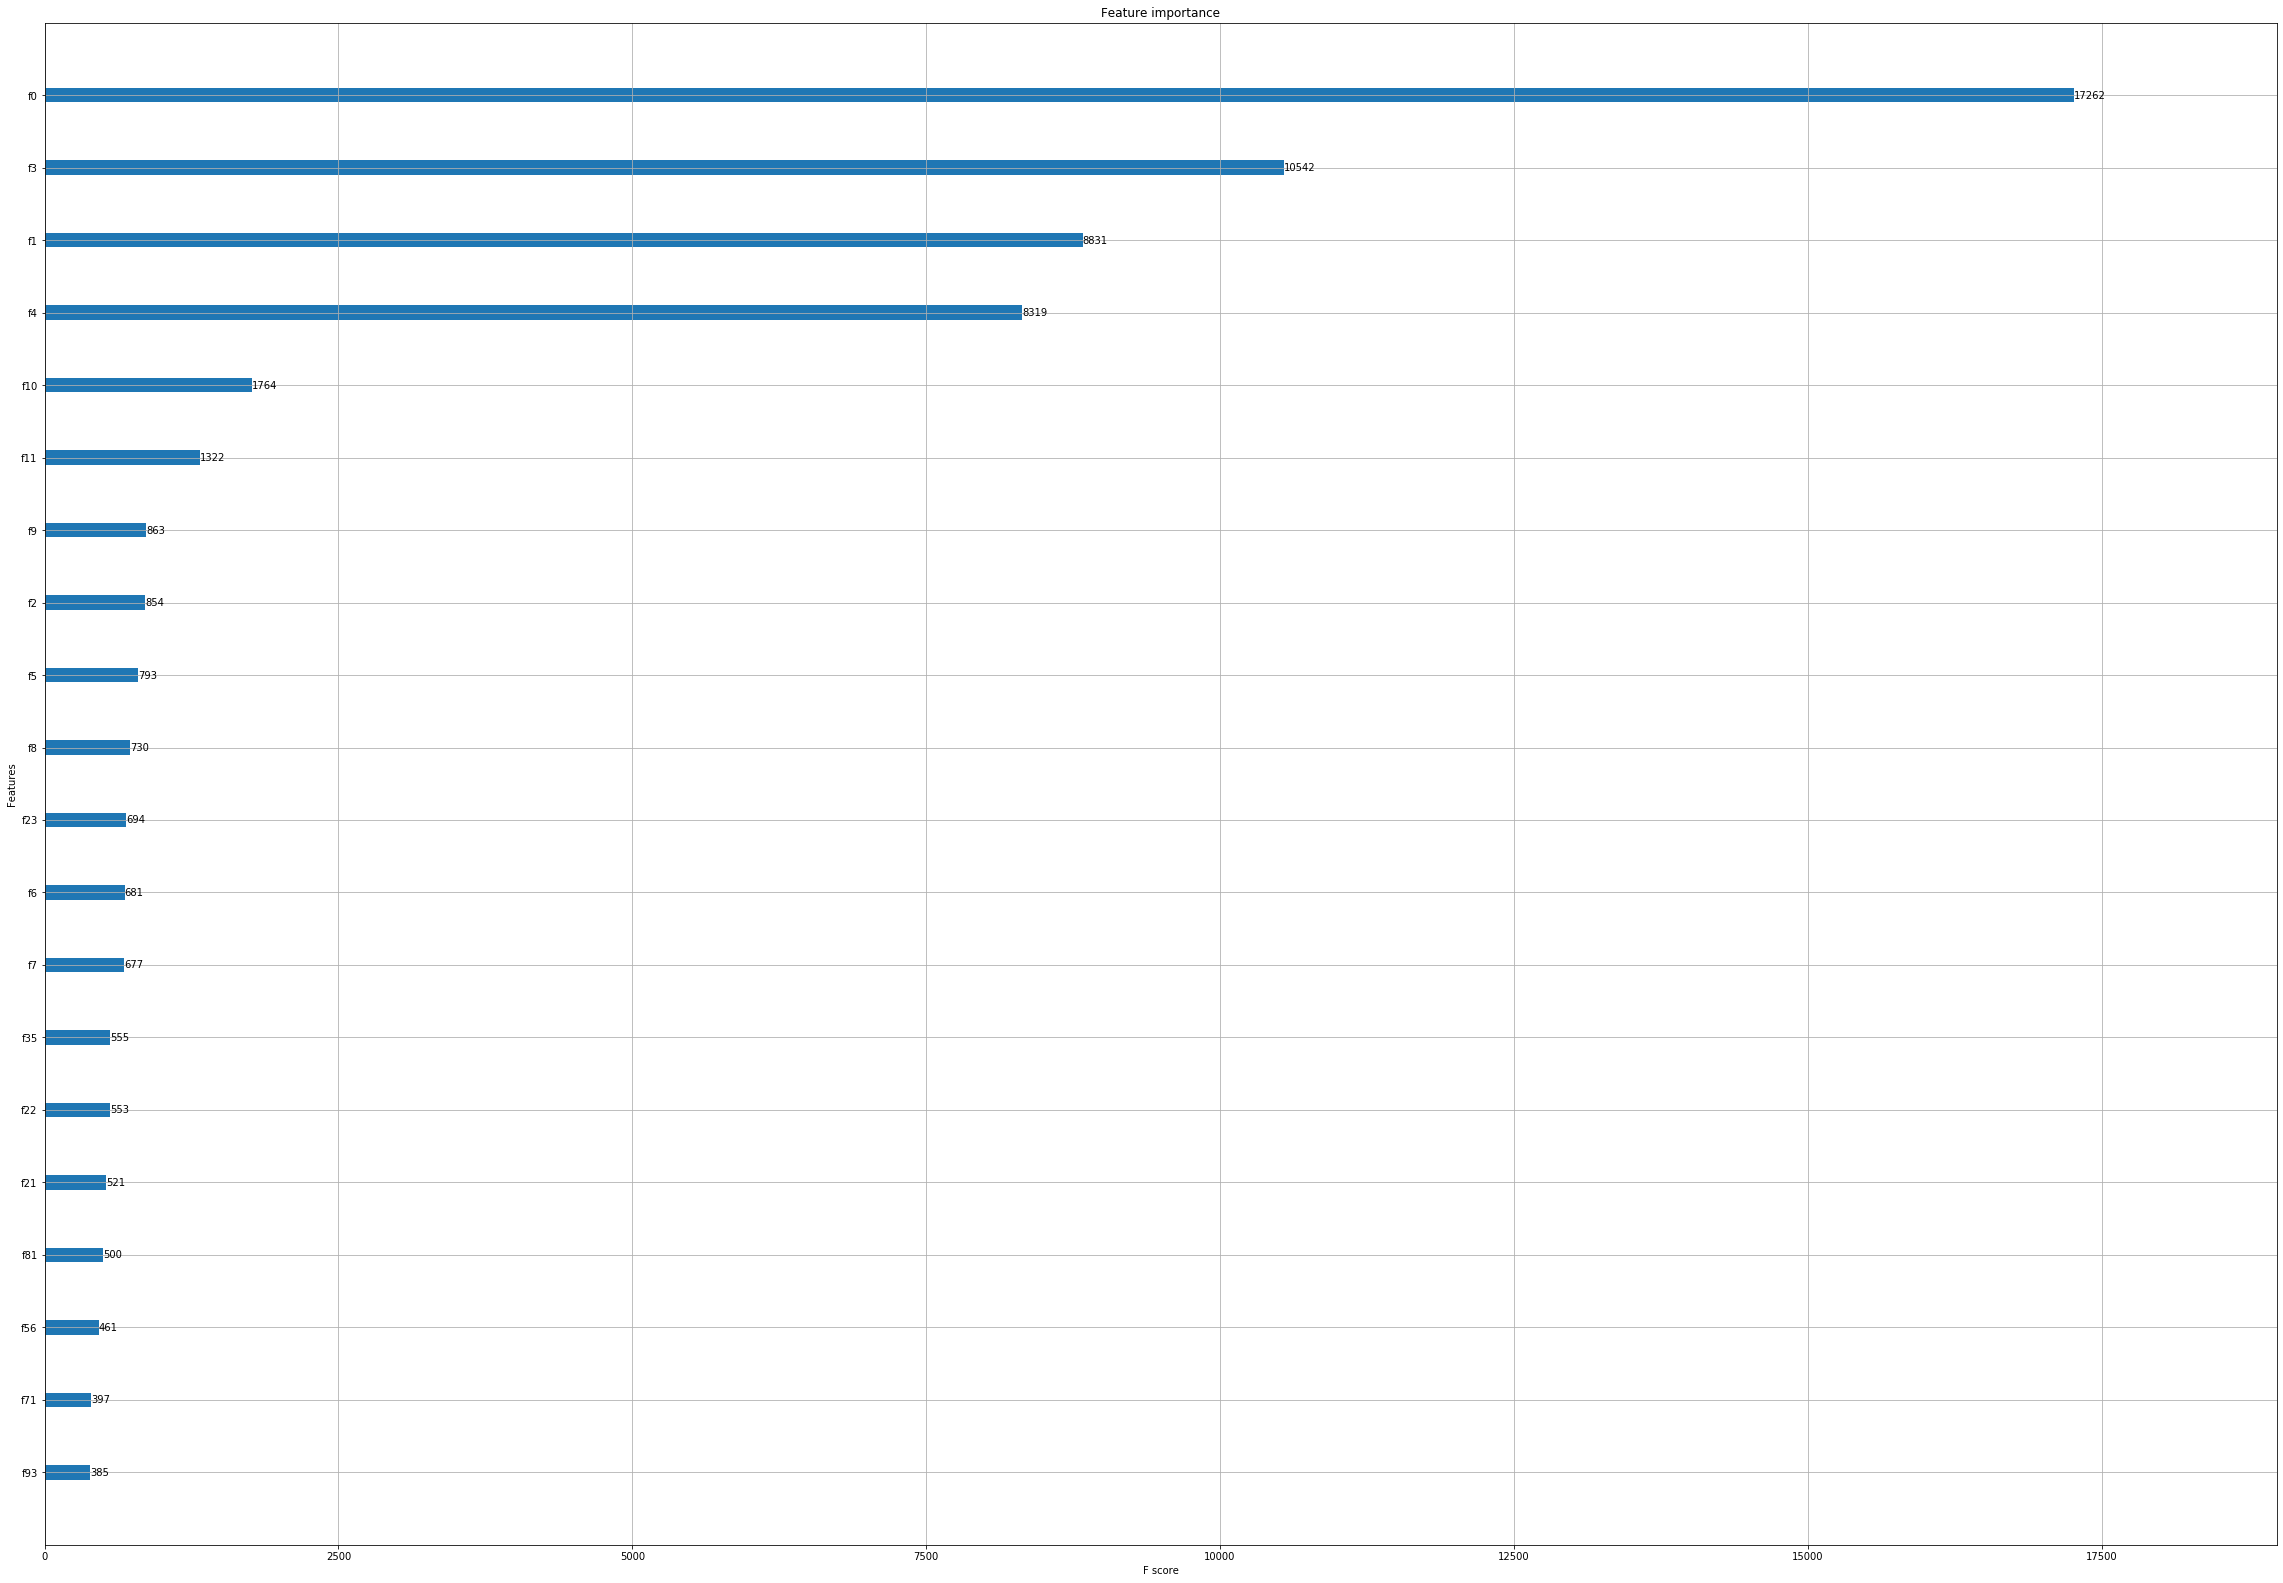

In [73]:
from pylab import rcParams
rcParams['figure.figsize'] = 40, 28
xgboost.plot_importance(grids[ind].best_estimator_[1],max_num_features=20)

In [74]:
X.columns

Index(['Hour', 'Month', 'Temperature', 'Relative Humidity',
       'Total Precipitation', 'Wind Speed', 'Wind Direction', 'holiday',
       'num_of_week', 'which_weekday'],
      dtype='object')

In [78]:
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
ohe.fit_transform(X[['Hour']])
ohe.get_feature_names(['Hour'])

array(['Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5',
       'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11',
       'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17',
       'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23'],
      dtype=object)

In [80]:
24+11

35

In [ ]:
f93 94 95 96 97 98 99

In [81]:
24+12+6

42

In [82]:
42+39

81

In [83]:
39/52

0.75

In [84]:
4*11

44

In [85]:
71-42

29

In [86]:
56-42

14

In [ ]:
March, 